In [1]:
#%source bin/activate
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

cos, sin = np.cos, np.sin
twopi = np.pi*2.0

In [2]:
rundir = "/home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/"
trndir = rundir+"train/"
testdir = rundir+"test/"

trnlist = [trndir+"djam", trndir+"tjam", trndir+"xjam", trndir+"ljam", trndir+"ujam"]
testlist = [testdir+"djam", testdir+"tjam", testdir+"xjam", testdir+"ljam", testdir+"ujam"]

fulllist = trnlist+testlist

file_append = "_th"

In [3]:
# Compile training set
gridx, gridy = 10,10 # num cells

# Edgelength is always 1.
width,height = 1.,1.

flist = fulllist
for fname in flist:
#     fname = flist[f]
    print "Processing " + fname + " as training data"
    fin = open(fname, 'r')
    fout = open(fname+file_append, 'w')
    thgrid = np.zeros(shape=(gridx,gridy))
    thgrid_refs = np.zeros(shape=(gridx,gridy))
    counts = np.zeros(shape=(gridx,gridy))
    dx,dy = width/float(gridx), height/float(gridy)
    nbl = 0
    xs,ys,thetas = [],[],[]
    specials = []
    for line in fin.readlines():
        if line == "\n": continue
        if line.startswith("label"):
            # Done a block
            for x,y,th in zip(xs,ys,thetas):
                xi = int(x/dx)
                yi = int(y/dy)
                i = gridx*xi + yi
                # th is initially in range [0,1.] corresponding to [0,2pi]
                # arctan2 outputs in range [-pi,pi]
                # difference between arctan and arctan2 is that
                # arctan only "folds back" the range [-pi/2,pi/2]
                if th > 0.5: th = -1. + th # th: [-0.5,0.5]
                if thgrid_refs[xi,yi] == 0.:
                    # get it a 'safe' distance from modpoint for
                    # angle comparisons later
                    if th > 0.25: th -= 0.5
                    if th < -0.25: th += 0.5
                    if i in specials:
                        print "adding ", str(th)
                        
                    thgrid_refs[xi,yi] = th
                else:
                    thref = thgrid_refs[xi,yi]
                    if (th > thref) and ((th - thref) > 0.25): th -= 0.5
                    if (th < thref) and ((thref - th) > 0.25): th += 0.5

                # return theta to [0,1] range
                # That way empty cells will be 0. and
                # look dead to the NN
                th += 0.5
                
                thgrid[xi,yi] += th
                counts[xi,yi] += 1
                if i in specials:
                    print nbl,i,th,thgrid[xi,yi]/counts[xi,yi]
                
            np.divide(thgrid,counts,out=thgrid,where=(counts>0.))
            # Write block
            dline = []
            for i in range(gridx):
                for j in range(gridy):
                    dline.append(thgrid[i,j])
            strdline = ""
            for d in dline:
                strdline += str(d)+" "
            strdline = strdline[:-1]
            fout.write(strdline+"\n")

            # After writing the theta grid block, append the label
            fout.write(line+"\n")
            # Reset arrays
            thgrid = np.zeros(shape=(gridx,gridy))
            thgrid_refs = np.zeros(shape=(gridx,gridy))
            counts = np.zeros(shape=(gridx,gridy))
            xs = []
            ys = []
            thetas = []
            nbl+=1
            continue
        spt = [float(x) for x in line.split()]
        xs.append(spt[0])
        ys.append(spt[1])
        thetas.append(spt[2])

    fin.close()
    fout.close()
print "Done compiling training set"

Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/train/djam as training data
Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/train/tjam as training data
Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/train/xjam as training data
Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/train/ljam as training data
Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/train/ujam as training data
Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/test/djam as training data
Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/test/tjam as training data
Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/test/xjam as training data
Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/test/ljam as training data
Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/test/ujam as training data
Done compiling training set


In [3]:
def plotLine(x1,y1,x2,y2):
    plt.gca().plot([x1, x2], [y1, y2], color='b', linestyle='-', linewidth=0.2)

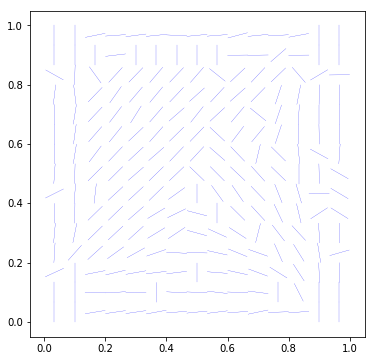

In [8]:
iSnap = 1
dx,dy = 1./gridx, 1./gridy

f = plt.figure()
# a = plt.Axes(f, [0., 0., 1., 1.])
# a.set_axis_off()
# f.add_axes(a)
# plt.xlim(-w/2,w/2)
# plt.ylim(-h/2,h/2)
# plt.xticks([])
# plt.yticks([])


dfile = open(trnlist[1]+file_append, "r")
iSnap = 1
cntSnap = 0
for line in dfile.readlines():
    if cntSnap > iSnap: break
    if cntSnap == iSnap:
        l = [float(x) for x in line.split()]
        for ix in range(gridx):
            for iy in range(gridy):
                i = int(gridx*ix + iy)
                th = l[i]
                x,y = dx*ix+dx/2., dy*iy+dy/2.
                # Note th=0 is along the y-axis
                x1 = x - (dx/2.)*sin(th*twopi) 
                y1 = y + (dy/2.)*cos(th*twopi)
                x2 = x + (dx/2.)*sin(th*twopi)
                y2 = y - (dy/2.)*cos(th*twopi)
        
                plotLine(x1,y1,x2,y2)
        cntSnap += 1
    else: 
        if line == "\n": cntSnap+=1
dfile.close()
plt.gcf().set_size_inches(6,6)